# AOS_comCam_set

Generate in-focus, and intra/extra focal images for https://sitcomtn-006.lsst.io/  for comCam 
    


    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib

In [6]:
# Run phosim : 
import os   


phosim_path = "/project/scichris/aos/phosim_syseng4/phosim.py"
root_dir = "/project/scichris/aos/imagesComcam/arrows"

for position in ['Focal','Extra','Intra']:
    inst_file = os.path.join(root_dir, f"star{position}.inst")
    instr = 'comcam'
    cmd_file = os.path.join(root_dir, 'noBkgnd.cmd')

    work_dir = os.path.join(root_dir, position.lower())
    out_dir = os.path.join(work_dir, 'raw')
    repackaged_dir = os.path.join(work_dir, "repackaged")
    log_file = os.path.join(work_dir, 'starPhosim.log')

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    command = f"python {phosim_path} {inst_file} -i {instr} -e 1 \
    -c {cmd_file} -p 25 -o {out_dir} > {log_file} 2>&1"
    print("\n", command)   


 python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/imagesComcam/arrows/starFocal.inst -i comcam -e 1     -c /project/scichris/aos/imagesComcam/arrows/noBkgnd.cmd -p 25 -o /project/scichris/aos/imagesComcam/arrows/focal/raw > /project/scichris/aos/imagesComcam/arrows/focal/starPhosim.log 2>&1

 python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/imagesComcam/arrows/starExtra.inst -i comcam -e 1     -c /project/scichris/aos/imagesComcam/arrows/noBkgnd.cmd -p 25 -o /project/scichris/aos/imagesComcam/arrows/extra/raw > /project/scichris/aos/imagesComcam/arrows/extra/starPhosim.log 2>&1

 python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/imagesComcam/arrows/starIntra.inst -i comcam -e 1     -c /project/scichris/aos/imagesComcam/arrows/noBkgnd.cmd -p 25 -o /project/scichris/aos/imagesComcam/arrows/intra/raw > /project/scichris/aos/imagesComcam/arrows/intra/starPhosim.log 2>&1


In [31]:
# Repackage, adding 'FOCUSZ' in the header of complete images 

# the information about focusz can't be taken from the phosim image as there
# isn't anything recording the MOVE commands .... 

# I added it as a new kwarg to the class initialization

# repackage:
instr='comcam'

focuszDic = {'Focal':0, 'Extra':-1500, 'Intra':1500}
for position in ['Focal','Extra','Intra']:
    
    focusz = focuszDic[position]
    work_dir = os.path.join(root_dir, position.lower())
    out_dir = os.path.join(work_dir, 'raw')
    repackaged_dir = os.path.join(work_dir, "repackaged")
    command = f"phosim_repackager.py {out_dir} --out_dir {repackaged_dir} --inst {instr} --focusz {focusz}"
    print("\n",command)


 phosim_repackager.py /project/scichris/aos/imagesComcam/arrows/focal/raw --out_dir /project/scichris/aos/imagesComcam/arrows/focal/repackaged --inst comcam --focusz 0

 phosim_repackager.py /project/scichris/aos/imagesComcam/arrows/extra/raw --out_dir /project/scichris/aos/imagesComcam/arrows/extra/repackaged --inst comcam --focusz -1500

 phosim_repackager.py /project/scichris/aos/imagesComcam/arrows/intra/raw --out_dir /project/scichris/aos/imagesComcam/arrows/intra/repackaged --inst comcam --focusz 1500


### Ensure that the FOCUSZ header is there and is correct : 

In-focus : `FOCUSZ` should be 0 

In [28]:
hdul = fits.open('/project/scichris/aos/imagesComcam/arrows/focal/repackaged/CC_H_20000217_006000_R22_S00.fits')
hdul[0].header['FOCUSZ']

0

Extra-focal : `FOCUSZ` should be -1500 

In [30]:
hdul = fits.open('/project/scichris/aos/imagesComcam/arrows/extra/repackaged/CC_H_20000217_006001_R22_S00.fits')
hdul[0].header['FOCUSZ']

-1500.0

Intra-focal : `FOCUSZ` should be +1500 

In [32]:
hdul = fits.open('/project/scichris/aos/imagesComcam/arrows/intra/repackaged/CC_H_20000217_006002_R22_S00.fits')
hdul[0].header['FOCUSZ']

1500.0

# Show the images 

Text(0.5, 1.0, 'LSSTComCam, R22_S02 (ITL)')

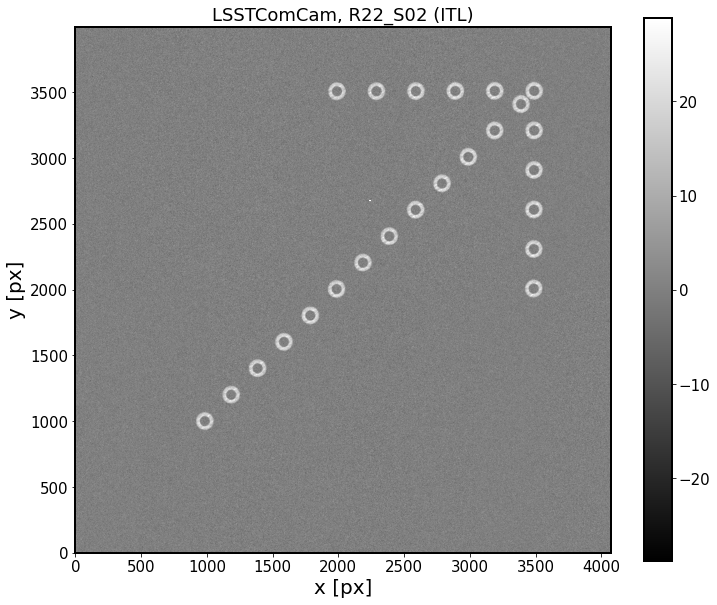

In [33]:
# show the postISR image 
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

path_to_repo = '/project/scichris/aos/imagesComcam/arrows/extra/DATA/'
butler = dafButler.Butler(path_to_repo)
registry = butler.registry


instrument = 'LSSTComCam'
dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

expN = dataset.dataId["exposure"]


exposure = butler.get('postISRCCD', detector='R22_S02', instrument=instrument,exposure=expN,
          collections=['run1'])


data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'{instrument}, {detector.getName()} ({detector.getSerial()[:3]})')